# Note
Alternative script using the data from an alternative pretreatment routine (i.e. routine 4)
Generally the errors are higher than when using routines 3, 3 - this was just used to test the effect of using a complete dataset (as mean imputation is used in routine 3) compared to a reduced data set (as due to predictor routine 3).

# Load model performance summary object


In [2]:
# Get directory path
import os
directory = os.getcwd()

# Specify filename
filename = "GBR_performance_summary_opt_alternative_4_3"

# Show full filepath
full_file_path_GBR = directory + r"\\" + filename
print("Full path to file:", full_file_path_GBR)


def load_performance_summary(full_file_path):
    import pickle
    performance_df = pickle.load(open(full_file_path, "rb"))
    return performance_df

# Get performance summary object
perf_summary = load_performance_summary(full_file_path_GBR)
# perf_summary # show importet dataframe

# Get column labels of performance summary object
column_labels = perf_summary.columns


Full path to file: C:\Users\2270577A\PycharmProjects\PhD_LCA_TEA\notebooks\Interpretable_ML_Gasification_Publication\\GBR_performance_summary_opt_alternative_4_3


In [3]:
# Get general variables
column_labels = perf_summary.columns
print(column_labels)


Index(['N2 [vol.% db]', 'H2 [vol.% db]', 'CO [vol.% db]', 'CO2 [vol.% db]',
       'CH4 [vol.% db]', 'C2Hn [vol.% db]', 'LHV [MJ/Nm3]', 'Tar [g/Nm3]',
       'Gas yield [Nm3/kg wb]', 'Char yield [g/kg wb]'],
      dtype='object')


In [82]:
# Check length of arrays for this dataset

perf_summary[column_labels[0]]["x_train"]
perf_summary[column_labels[0]]["x_test"]
print("total predictions = 47 + 265")
# 47 + 265

total predictions = 47 + 265


# Define general functions required

In [4]:
# Define function to get cross validated predictions for model output
def get_CV_predictions_df(column_label):
    # Load model itself
    import pickle
    model = pickle.loads(perf_summary[column_label]['model'])

    # Calculate CV score again
    import pandas as pd
    import numpy as np

    # Combine datasets again before calculating cross validation scores
    x_complete = np.array(pd.concat([perf_summary[column_label]['x_train'],
                                     perf_summary[column_label]['x_test']]))
    y_complete = np.array(pd.concat([perf_summary[column_label]['y_train'],
                                     perf_summary[column_label]['y_test']]))

    from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
    
    # Calculate and print cross validated R2 scores
    from math import sqrt
    CV_R2_scores = cross_val_score(model, x_complete, y_complete, cv=5, scoring='r2')
    CV_MSE_scores= cross_val_score(model, x_complete, y_complete, cv=5, scoring='neg_mean_squared_error')

    # print("CV R2 scores: ", CV_R2_scores)
    print("Averaged CV R2 score: ", np.mean(CV_R2_scores))
    print("Averaged CV RMSE score: ", sqrt(-np.mean(CV_MSE_scores)))

    # # Get individual cross_validated models
    # Cross_val_test = cross_validate(model, x_complete, y_complete, return_estimator=True)
    # print("CV R2 score: ", Cross_val_test) 
    
    # Get cross validated predictions
    cv_predictions = cross_val_predict(model, x_complete, y_complete)

    # Create Dataframe to store targets and predictions
    import pandas as pd
    summary_df = pd.DataFrame([y_complete, cv_predictions]).transpose()
    summary_df.columns = ["targets", "predictions"]

    import matplotlib.pyplot as plt
    plt.scatter(cv_predictions, y_complete)
    # Note: Targets and predictors swapped here in this graph - this way would split along x-axis (i.e. vertical lines)
    plt.xlabel("Predictions")
    plt.ylabel("Targets")
    plt.show()
    
    return summary_df


In [5]:
# Kernel density estimation calculation and plots for tuning
def Kernel_Density_Tuning(summary_df, bandwidth):
    import numpy as np
    import pandas as pd
    from sklearn.neighbors import KernelDensity
    from scipy.signal import argrelextrema
    import matplotlib.pyplot as plt
    updated_summary_df = summary_df.copy()
    
    # Fit Kernel density model 
    pred = np.array(summary_df['predictions']).reshape(-1, 1) # get prediction in right formation for training
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pred) # fit kernel density estimation model
    scaling_var = (max(summary_df['predictions'])- min(summary_df['predictions']))*0.10 # get scaling variable for plotting
    x_axis = np.linspace(min(summary_df['predictions']) - scaling_var, max(summary_df['predictions']) + scaling_var) # create x-axis for plotting
    y = kde.score_samples(x_axis.reshape(-1,1)) # create curve
    
    kde_min_idx, kde_max_idx = argrelextrema(y, np.less)[0], argrelextrema(y, np.greater)[0] # get indices of minima and maxima of curve 
    minimas = x_axis[kde_min_idx] # extract minimas
    maximas = x_axis[kde_max_idx] # extract maximas
    print("Minimas:", minimas)
    print("Maximas:", maximas)
    
    # Create array with bin limits
    bin_limits = list(minimas.copy()) # get cut-offs
    bin_limits.append(max(summary_df['predictions']))  # add max value of all predictions
    bin_limits.insert(0, min(summary_df['predictions'])) # add min value of all predictions
    print("Bin Limits:", bin_limits)
    
    # add bin label column to dataframe
    bins = ["bin_1"] # initialise bins list
    for count, items in enumerate(minimas): # extract number of bins required
        bins.append("bin_" + str(count+2))
    updated_summary_df['bins'] = pd.cut(updated_summary_df['predictions'],
                                       bins=bin_limits,
                                       labels=bins,
                                       include_lowest=True)
    
    # Show plots for tuning purposes
    
    # Plot Kernel density plot
    print('Kernel density plot')
    plt.plot(x_axis, y)
    plt.show()
    
    # Plot scatter plot with boundaries lines
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.scatterplot(x='predictions', y='targets', data=updated_summary_df, hue='bins', legend=False)
    # Add boundary lines to scatter plot
    for values in minimas:
        plt.axvline(x = values, color = 'r', linestyle ="--")
        
    # Add perfect fit line
    line = np.linspace(min(summary_df['predictions']),max(summary_df['predictions']))
    plt.plot(line, line,color = 'black', linewidth=1.5, linestyle='dashed', zorder=4)
                       
    plt.show()

    return minimas, updated_summary_df


In [6]:
# Function used to calculate errors for different bins and store values in storage dataframe 
def calc_store_errors(summary_df_bins,boundaries, storage_df, column_label):
    """
    Function used to calculate errors for different bins and store values in storage dataframe
    
    Parameters
    ----------
    summary_df_bins
    boundaries
    storage_df: Data frame in which information will be stored
    column_label: Determines which column values should be stored in
    Returns
    -------
    """

    # Calculate error values
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    #Initialise lists for storage
    RMSE = []
    R2 = []
    for count,bins in enumerate(np.sort(summary_df_bins["bins"].unique())):
        predictions_in_bin = summary_df_bins["predictions"].loc[summary_df_bins["bins"]==bins]
        targets_in_bin = summary_df_bins["targets"].loc[summary_df_bins["bins"]==bins]
        RMSE.append(mean_squared_error(targets_in_bin, predictions_in_bin, squared=False))
        R2.append(r2_score(targets_in_bin, predictions_in_bin))
    
        # print(bins)
        # print(predictions_in_bin)
        # print(targets_in_bin)

    # Store values in data frame
    storage_df[column_label]["boundaries"] = boundaries
    storage_df[column_label]["RMSE"] = RMSE
    storage_df[column_label]["R2"] = R2

    return storage_df


In [7]:
# Function to execute all stages
def exec_steps(output_label_no, tuned_bandwidth, storage_df):
    
    print("Functions are being executed for", column_labels[output_label_no])
    # Execute functions
    summary_df = get_CV_predictions_df(column_labels[output_label_no])
    boundaries, summary_df_bins = Kernel_Density_Tuning(summary_df, bandwidth=tuned_bandwidth)
    updated_storage_df = calc_store_errors(summary_df_bins, boundaries, storage_df, column_label=column_labels[output_label_no])
    
    # Print scores
    print("R2 values:", storage_df[column_labels[output_label_no]]["R2"])
    print("RMSE value:", storage_df[column_labels[output_label_no]]["RMSE"])
    
    return updated_storage_df

# Initialise Dataframe to store boundaries and errors


In [8]:
import pandas as pd
storage_df = pd.DataFrame(index=["boundaries","RMSE","R2"] ,columns=column_labels)
storage_df

,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis for Output 1: Syngas N2 content

Functions are being executed for N2 [vol.% db]
Averaged CV R2 score:  0.9742643474549686
Averaged CV RMSE score:  4.240809258218863


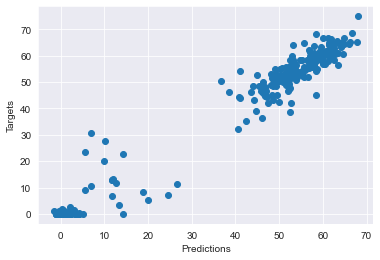

Minimas: [10.21010406 32.38343656]
Maximas: [-2.37417099e-02  1.19157450e+01  5.96736919e+01]
Bin Limits: [-1.5872459245760266, 10.21010405875758, 32.383436557553274, 68.0597600011284]
Kernel density plot


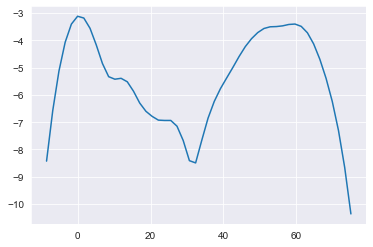

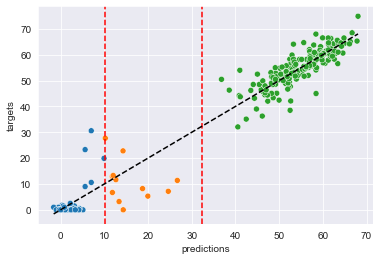

R2 values: [0.3919357588519806, -1.3089060687003413, 0.7036777624432229]
RMSE value: [3.35147733371544, 11.042459810273627, 3.8355124246344316]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",NaN,NaN,[],[],[],[],"[123.73984599657547, 154.19689991563888, 209.0...",[4.18718074593577],"[31.697575869924222, 74.52974245223884, 111.24..."
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...",NaN,NaN,[2.6855878455825533],[1.6153286749071962],[0.8165509186053537],[0.7911127034938502],"[11.46127678012522, 7.694307537631845, 17.6877...","[0.19590995879303066, 0.3935721193581885]","[7.814046934003311, 10.111850715668053, 32.228..."
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...",NaN,NaN,[0.8244328353466756],[0.7620071470324578],[0.6494053116537801],[0.947704633419546],"[0.7834329512986757, -0.5768487317344755, -0.0...","[0.8892728999026727, 0.5848043777252367]","[0.5604942112426688, 0.47946121563777044, 0.07..."


In [24]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(0, 2.6, storage_df)

# Analysis for Output 2: Syngas H2 content

Functions are being executed for H2 [vol.% db]
Averaged CV R2 score:  0.920884418136243
Averaged CV RMSE score:  4.86409489581268


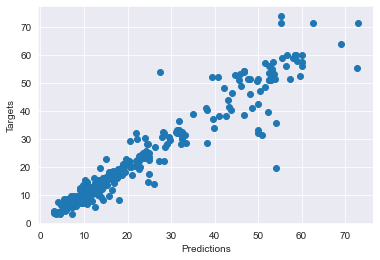

Minimas: [38.83560254]
Maximas: [ 9.73196161 52.53143356]
Bin Limits: [3.0267110019962575, 38.83560253855907, 72.93251519687983]
Kernel density plot


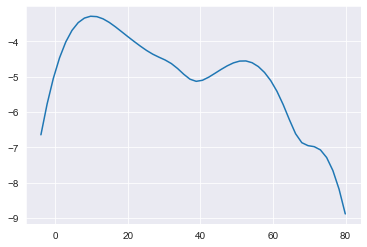

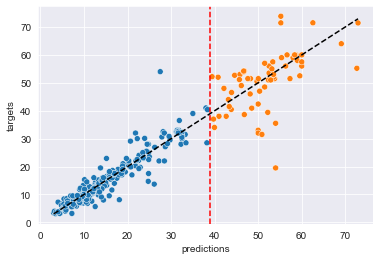

R2 values: [0.8791900651964895, 0.27101142386539145]
RMSE value: [3.18012534634988, 8.685800396154434]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",[38.83560253855907],NaN,[],[],[],[],"[123.73984599657547, 154.19689991563888, 209.0...",[4.18718074593577],"[31.697575869924222, 74.52974245223884, 111.24..."
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...","[3.18012534634988, 8.685800396154434]",NaN,[2.6855878455825533],[1.6153286749071962],[0.8165509186053537],[0.7911127034938502],"[11.46127678012522, 7.694307537631845, 17.6877...","[0.19590995879303066, 0.3935721193581885]","[7.814046934003311, 10.111850715668053, 32.228..."
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...","[0.8791900651964895, 0.27101142386539145]",NaN,[0.8244328353466756],[0.7620071470324578],[0.6494053116537801],[0.947704633419546],"[0.7834329512986757, -0.5768487317344755, -0.0...","[0.8892728999026727, 0.5848043777252367]","[0.5604942112426688, 0.47946121563777044, 0.07..."


In [28]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(1, 4, storage_df)

# Analysis for Output 3: Syngas CO content

Functions are being executed for CO [vol.% db]
Averaged CV R2 score:  0.8158728528765675
Averaged CV RMSE score:  3.9421030389613736


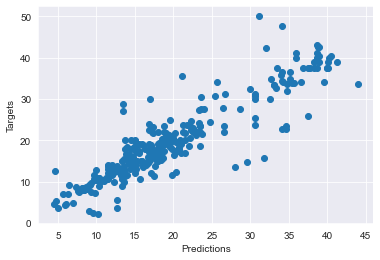

Minimas: [28.57167205]
Maximas: [15.98508904 36.3172616 ]
Bin Limits: [4.447387939606902, 28.571672050532435, 43.98216792072232]
Kernel density plot


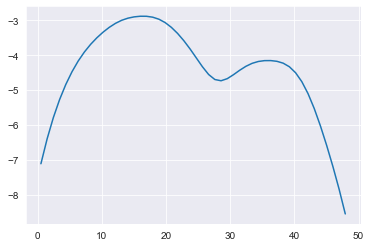

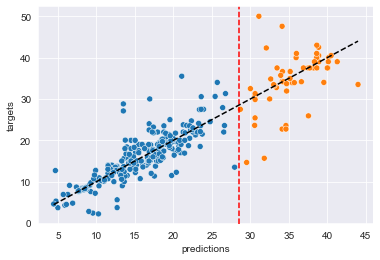

R2 values: [0.6835323088743619, 0.2266658563578553]
RMSE value: [3.311106988818368, 5.967826449699107]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",[38.83560253855907],[28.571672050532435],[],[],[],[],"[123.73984599657547, 154.19689991563888, 209.0...",[4.18718074593577],"[31.697575869924222, 74.52974245223884, 111.24..."
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...","[3.18012534634988, 8.685800396154434]","[3.311106988818368, 5.967826449699107]",[2.6855878455825533],[1.6153286749071962],[0.8165509186053537],[0.7911127034938502],"[11.46127678012522, 7.694307537631845, 17.6877...","[0.19590995879303066, 0.3935721193581885]","[7.814046934003311, 10.111850715668053, 32.228..."
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...","[0.8791900651964895, 0.27101142386539145]","[0.6835323088743619, 0.2266658563578553]",[0.8244328353466756],[0.7620071470324578],[0.6494053116537801],[0.947704633419546],"[0.7834329512986757, -0.5768487317344755, -0.0...","[0.8892728999026727, 0.5848043777252367]","[0.5604942112426688, 0.47946121563777044, 0.07..."


In [29]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(2, 2.5, storage_df)

# Analysis for Output 4: Syngas CO2 content

Functions are being executed for CO2 [vol.% db]
Averaged CV R2 score:  0.8141980392410358
Averaged CV RMSE score:  2.6849147634808235


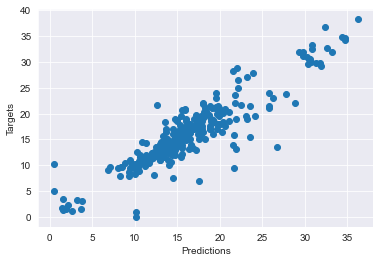

Minimas: [ 4.75645558 26.67013957]
Maximas: [ 2.1268135  15.27502389 31.05287636]
Bin Limits: [0.4467643933741057, 4.756455577787663, 26.670139566331173, 36.239114907995166]
Kernel density plot


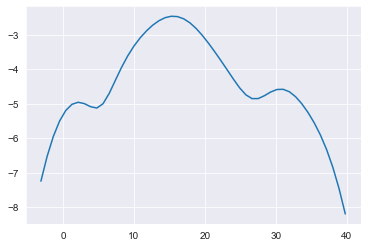

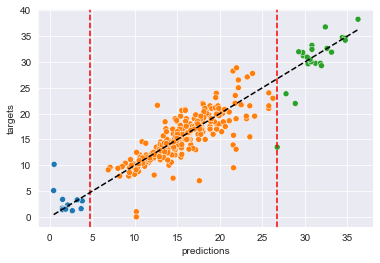

R2 values: [-0.7518091795054109, 0.6175487033956719, 0.48150000426654815]
RMSE value: [3.111886689720186, 2.5753794092946065, 3.5379728824841443]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",[38.83560253855907],[28.571672050532435],"[4.756455577787663, 26.670139566331173]",[],[],[],"[123.73984599657547, 154.19689991563888, 209.0...",[4.18718074593577],"[31.697575869924222, 74.52974245223884, 111.24..."
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...","[3.18012534634988, 8.685800396154434]","[3.311106988818368, 5.967826449699107]","[3.111886689720186, 2.5753794092946065, 3.5379...",[1.6153286749071962],[0.8165509186053537],[0.7911127034938502],"[11.46127678012522, 7.694307537631845, 17.6877...","[0.19590995879303066, 0.3935721193581885]","[7.814046934003311, 10.111850715668053, 32.228..."
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...","[0.8791900651964895, 0.27101142386539145]","[0.6835323088743619, 0.2266658563578553]","[-0.7518091795054109, 0.6175487033956719, 0.48...",[0.7620071470324578],[0.6494053116537801],[0.947704633419546],"[0.7834329512986757, -0.5768487317344755, -0.0...","[0.8892728999026727, 0.5848043777252367]","[0.5604942112426688, 0.47946121563777044, 0.07..."


In [32]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=3, tuned_bandwidth=2.2, storage_df=storage_df)

# Analysis for Output 5: Syngas CH4 content

Functions are being executed for CH4 [vol.% db]
Averaged CV R2 score:  0.764667626750849
Averaged CV RMSE score:  1.6168556758872414


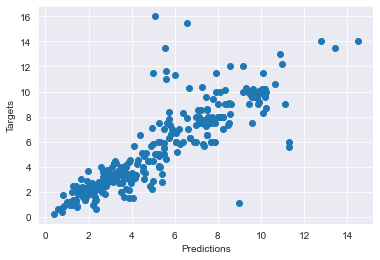

Minimas: [6.57668281]
Maximas: [2.77293119 7.61406962]
Bin Limits: [0.38117827631630563, 6.576682810073725, 14.50116535325182]
Kernel density plot


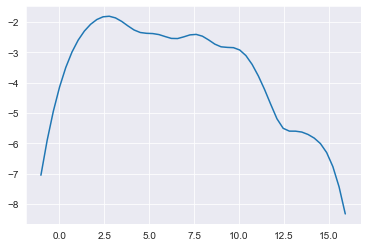

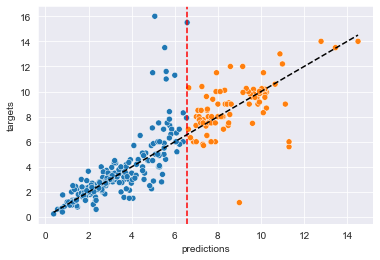

R2 values: [0.5593941477569797, 0.31928279884919275]
RMSE value: [1.6170179107793567, 1.6117416396164086]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",[38.83560253855907],[28.571672050532435],"[4.756455577787663, 26.670139566331173]",[6.576682810073725],[],[],"[123.73984599657547, 154.19689991563888, 209.0...",[4.18718074593577],"[31.697575869924222, 74.52974245223884, 111.24..."
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...","[3.18012534634988, 8.685800396154434]","[3.311106988818368, 5.967826449699107]","[3.111886689720186, 2.5753794092946065, 3.5379...","[1.6170179107793567, 1.6117416396164086]",[0.8165509186053537],[0.7911127034938502],"[11.46127678012522, 7.694307537631845, 17.6877...","[0.19590995879303066, 0.3935721193581885]","[7.814046934003311, 10.111850715668053, 32.228..."
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...","[0.8791900651964895, 0.27101142386539145]","[0.6835323088743619, 0.2266658563578553]","[-0.7518091795054109, 0.6175487033956719, 0.48...","[0.5593941477569797, 0.31928279884919275]",[0.6494053116537801],[0.947704633419546],"[0.7834329512986757, -0.5768487317344755, -0.0...","[0.8892728999026727, 0.5848043777252367]","[0.5604942112426688, 0.47946121563777044, 0.07..."


In [39]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=4, tuned_bandwidth=0.7, storage_df=storage_df)

# Analysis for Output 6: Syngas C2Hn content

Functions are being executed for C2Hn [vol.% db]
Averaged CV R2 score:  0.681836282796873
Averaged CV RMSE score:  0.8165509186053537


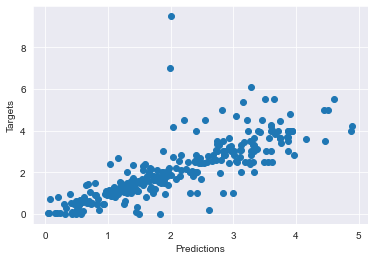

Minimas: [0.74539925 2.29235316]
Maximas: [0.62640279 1.34038152 3.00633189]
Bin Limits: [0.04133688998491021, 0.7453992476291028, 2.292353160199441, 4.900358794853281]
Kernel density plot


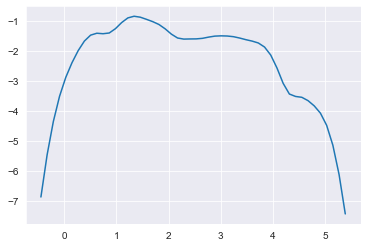

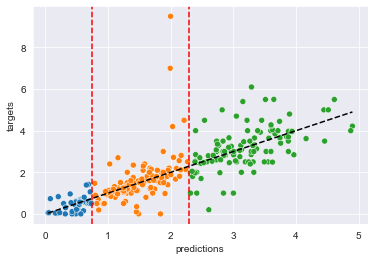

R2 values: [0.20868009750558214, 0.2343111284517969, 0.34313029417374097]
RMSE value: [0.3078736786212894, 0.9020313013047787, 0.8299158073175483]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",[38.83560253855907],[28.571672050532435],"[4.756455577787663, 26.670139566331173]",[6.576682810073725],"[0.7453992476291028, 2.292353160199441]",[],"[123.73984599657547, 154.19689991563888, 209.0...",[4.18718074593577],"[31.697575869924222, 74.52974245223884, 111.24..."
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...","[3.18012534634988, 8.685800396154434]","[3.311106988818368, 5.967826449699107]","[3.111886689720186, 2.5753794092946065, 3.5379...","[1.6170179107793567, 1.6117416396164086]","[0.3078736786212894, 0.9020313013047787, 0.829...",[0.7911127034938502],"[11.46127678012522, 7.694307537631845, 17.6877...","[0.19590995879303066, 0.3935721193581885]","[7.814046934003311, 10.111850715668053, 32.228..."
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...","[0.8791900651964895, 0.27101142386539145]","[0.6835323088743619, 0.2266658563578553]","[-0.7518091795054109, 0.6175487033956719, 0.48...","[0.5593941477569797, 0.31928279884919275]","[0.20868009750558214, 0.2343111284517969, 0.34...",[0.947704633419546],"[0.7834329512986757, -0.5768487317344755, -0.0...","[0.8892728999026727, 0.5848043777252367]","[0.5604942112426688, 0.47946121563777044, 0.07..."


In [45]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=5, tuned_bandwidth=0.2, storage_df=storage_df)

# Analysis for Output 7: Syngas LHV

Functions are being executed for LHV [MJ/Nm3]
Averaged CV R2 score:  0.9453002025388646
Averaged CV RMSE score:  0.7921046839518157


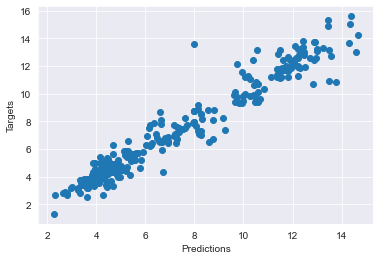

Minimas: [9.2260386]
Maximas: [ 4.36697363 11.65557108]
Bin Limits: [2.2664403355770277, 9.22603859588041, 14.667179053935785]
Kernel density plot


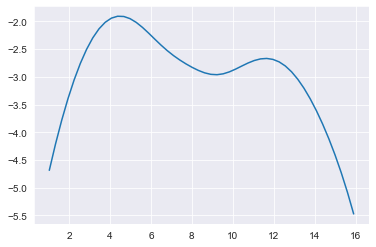

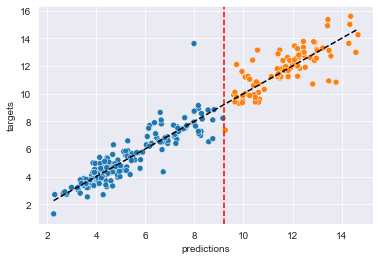

R2 values: [0.825760740642086, 0.602395556567763]
RMSE value: [0.7194279623378563, 0.9344516203564501]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",[38.83560253855907],[28.571672050532435],"[4.756455577787663, 26.670139566331173]",[6.576682810073725],"[0.7453992476291028, 2.292353160199441]",[9.22603859588041],"[123.73984599657547, 154.19689991563888, 209.0...",[4.18718074593577],"[31.697575869924222, 74.52974245223884, 111.24..."
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...","[3.18012534634988, 8.685800396154434]","[3.311106988818368, 5.967826449699107]","[3.111886689720186, 2.5753794092946065, 3.5379...","[1.6170179107793567, 1.6117416396164086]","[0.3078736786212894, 0.9020313013047787, 0.829...","[0.7194279623378563, 0.9344516203564501]","[11.46127678012522, 7.694307537631845, 17.6877...","[0.19590995879303066, 0.3935721193581885]","[7.814046934003311, 10.111850715668053, 32.228..."
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...","[0.8791900651964895, 0.27101142386539145]","[0.6835323088743619, 0.2266658563578553]","[-0.7518091795054109, 0.6175487033956719, 0.48...","[0.5593941477569797, 0.31928279884919275]","[0.20868009750558214, 0.2343111284517969, 0.34...","[0.825760740642086, 0.602395556567763]","[0.7834329512986757, -0.5768487317344755, -0.0...","[0.8892728999026727, 0.5848043777252367]","[0.5604942112426688, 0.47946121563777044, 0.07..."


In [51]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=6, tuned_bandwidth=1.2, storage_df=storage_df)

# Analysis for Output 8: Syngas Tar content

Functions are being executed for Tar [g/Nm3]
Averaged CV R2 score:  0.8984403695921586
Averaged CV RMSE score:  13.927135790622055


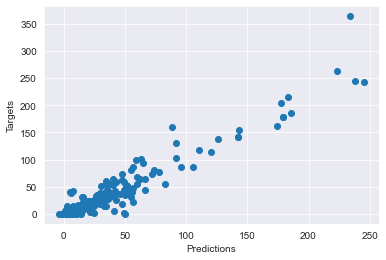

Minimas: [154.19689992 209.01959697]
Maximas: [ 14.09445189 178.56254305 233.38524011]
Bin Limits: [-3.672162898173221, 154.19689991563888, 209.01959696995306, 245.06044410751142]
Kernel density plot


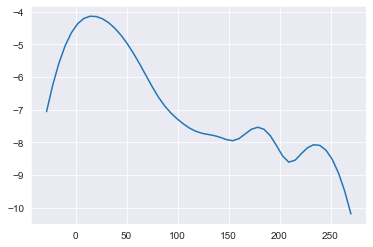

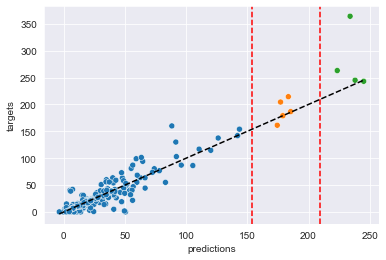

R2 values: [0.8358118436507159, -0.017253770952003755, -0.8647312698422969]
RMSE value: [11.417471877966316, 17.68777652079638, 68.04761112729467]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",[38.83560253855907],[28.571672050532435],"[4.756455577787663, 26.670139566331173]",[6.576682810073725],"[0.7453992476291028, 2.292353160199441]",[9.22603859588041],"[154.19689991563888, 209.01959696995306]",[4.18718074593577],"[31.697575869924222, 74.52974245223884, 111.24..."
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...","[3.18012534634988, 8.685800396154434]","[3.311106988818368, 5.967826449699107]","[3.111886689720186, 2.5753794092946065, 3.5379...","[1.6170179107793567, 1.6117416396164086]","[0.3078736786212894, 0.9020313013047787, 0.829...","[0.7194279623378563, 0.9344516203564501]","[11.417471877966316, 17.68777652079638, 68.047...","[0.19590995879303066, 0.3935721193581885]","[7.814046934003311, 10.111850715668053, 32.228..."
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...","[0.8791900651964895, 0.27101142386539145]","[0.6835323088743619, 0.2266658563578553]","[-0.7518091795054109, 0.6175487033956719, 0.48...","[0.5593941477569797, 0.31928279884919275]","[0.20868009750558214, 0.2343111284517969, 0.34...","[0.825760740642086, 0.602395556567763]","[0.8358118436507159, -0.017253770952003755, -0...","[0.8892728999026727, 0.5848043777252367]","[0.5604942112426688, 0.47946121563777044, 0.07..."


In [58]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(7, 15, storage_df)

# Analysis for Output 9: Syngas Yield

Functions are being executed for Gas yield [Nm3/kg wb]
Averaged CV R2 score:  0.9480188123483186
Averaged CV RMSE score:  0.2071246589451502


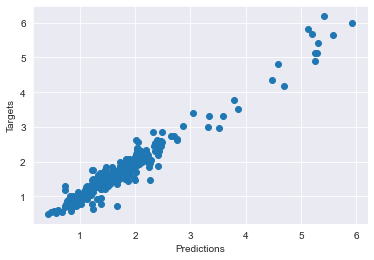

Minimas: [3.2444782  4.18718075]
Maximas: [1.6284167  3.51382179 5.26455508]
Bin Limits: [0.4275932270676125, 3.2444782038912168, 4.18718074593577, 5.92669138899417]
Kernel density plot


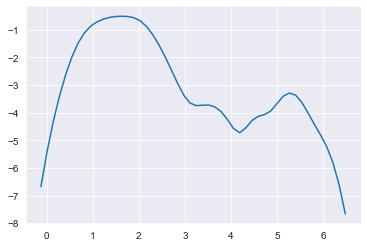

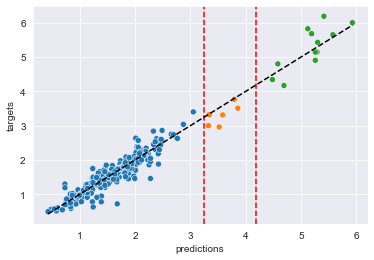

R2 values: [0.8725286187647469, -0.30836492131524085, 0.5848043777252367]
RMSE value: [0.1925381483268007, 0.31922518936202393, 0.3935721193581885]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",[38.83560253855907],[28.571672050532435],"[4.756455577787663, 26.670139566331173]",[6.576682810073725],"[0.7453992476291028, 2.292353160199441]",[9.22603859588041],"[154.19689991563888, 209.01959696995306]","[3.2444782038912168, 4.18718074593577]","[31.697575869924222, 74.52974245223884, 111.24..."
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...","[3.18012534634988, 8.685800396154434]","[3.311106988818368, 5.967826449699107]","[3.111886689720186, 2.5753794092946065, 3.5379...","[1.6170179107793567, 1.6117416396164086]","[0.3078736786212894, 0.9020313013047787, 0.829...","[0.7194279623378563, 0.9344516203564501]","[11.417471877966316, 17.68777652079638, 68.047...","[0.1925381483268007, 0.31922518936202393, 0.39...","[7.814046934003311, 10.111850715668053, 32.228..."
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...","[0.8791900651964895, 0.27101142386539145]","[0.6835323088743619, 0.2266658563578553]","[-0.7518091795054109, 0.6175487033956719, 0.48...","[0.5593941477569797, 0.31928279884919275]","[0.20868009750558214, 0.2343111284517969, 0.34...","[0.825760740642086, 0.602395556567763]","[0.8358118436507159, -0.017253770952003755, -0...","[0.8725286187647469, -0.30836492131524085, 0.5...","[0.5604942112426688, 0.47946121563777044, 0.07..."


In [65]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(8, 0.25, storage_df)

# Analysis for Output 10: Char Yield

Functions are being executed for Char yield [g/kg wb]
Averaged CV R2 score:  0.8114334564373429
Averaged CV RMSE score:  23.86466291488988


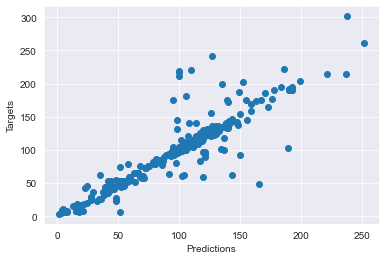

Minimas: [68.41086151]
Maximas: [ 50.05421869 117.36190903]
Bin Limits: [1.6130779132984865, 68.41086151190818, 251.46738297680037]
Kernel density plot


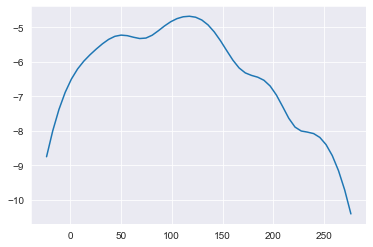

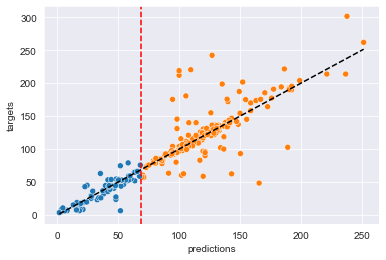

R2 values: [0.7624999553254127, 0.552421697759339]
RMSE value: [9.588905906299493, 27.716791366512012]


,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[10.21010405875758, 32.383436557553274]",[38.83560253855907],[28.571672050532435],"[4.756455577787663, 26.670139566331173]",[6.576682810073725],"[0.7453992476291028, 2.292353160199441]",[9.22603859588041],"[154.19689991563888, 209.01959696995306]","[3.2444782038912168, 4.18718074593577]",[68.41086151190818]
RMSE,"[3.35147733371544, 11.042459810273627, 3.83551...","[3.18012534634988, 8.685800396154434]","[3.311106988818368, 5.967826449699107]","[3.111886689720186, 2.5753794092946065, 3.5379...","[1.6170179107793567, 1.6117416396164086]","[0.3078736786212894, 0.9020313013047787, 0.829...","[0.7194279623378563, 0.9344516203564501]","[11.417471877966316, 17.68777652079638, 68.047...","[0.1925381483268007, 0.31922518936202393, 0.39...","[9.588905906299493, 27.716791366512012]"
R2,"[0.3919357588519806, -1.3089060687003413, 0.70...","[0.8791900651964895, 0.27101142386539145]","[0.6835323088743619, 0.2266658563578553]","[-0.7518091795054109, 0.6175487033956719, 0.48...","[0.5593941477569797, 0.31928279884919275]","[0.20868009750558214, 0.2343111284517969, 0.34...","[0.825760740642086, 0.602395556567763]","[0.8358118436507159, -0.017253770952003755, -0...","[0.8725286187647469, -0.30836492131524085, 0.5...","[0.7624999553254127, 0.552421697759339]"


In [71]:
# Execute code
# Change bandwidth until acceptable boundaries have been identified
exec_steps(output_label_no=9, tuned_bandwidth=15, storage_df=storage_df)

# Show final dataframe and pickle for later use


In [13]:
# Show dataframe with final boundaries and error scores
storage_df

,N2 [vol.% db],H2 [vol.% db],CO [vol.% db],CO2 [vol.% db],CH4 [vol.% db],C2Hn [vol.% db],LHV [MJ/Nm3],Tar [g/Nm3],Gas yield [Nm3/kg wb],Char yield [g/kg wb]
boundaries,"[7.103997154256467, 24.660512540869426]",[19.329524815261642],[27.94808518717715],NaN,NaN,NaN,NaN,[],[4.050075576868588],NaN
RMSE,"[1.3019879388229392, 10.665370060648973, 4.355...","[1.929565481796594, 3.7582787514464266]","[2.253470219036796, 2.5805378695930545]",NaN,NaN,NaN,NaN,[10.092894578921772],"[0.19692916190661833, 0.30820093190781744]",NaN
R2,"[-2.9042753019591006, -0.27784088339044843, 0....","[0.7742184471939392, 0.6089190981411567]","[0.8176516865119186, 0.49271019434991825]",NaN,NaN,NaN,NaN,[0.7817119079883612],"[0.8559226624722125, 0.7453920207635296]",NaN


In [14]:
# Store for later use
import pickle
# Store Peformance summary data frame of best performing model
with open("Prediction_boundaries_and_errors_df_4_3", "wb") as f:
    pickle.dump(storage_df, f)


In [15]:
# Example of how pickled data frame can be loaded
with open("Prediction_boundaries_and_errors_df", "rb") as f:
    loaded_df = pickle.load(f)


# Unused Code - Fisher-Jenks Algorithm

In [16]:
# # Implementation of Fisher-Jenks Algorithm
# # Currently unused as kernel density estimation has been producing better results
#
# def calculate_bins(nb_class):
#     import pandas as pd
#     import jenkspy
#
#     jenkspy_breaks = jenkspy.jenks_breaks(summary_df['predictions'], nb_class)
#     breaks = jenkspy_breaks.copy()
#     breaks.remove(max(breaks))
#     breaks.remove(min(breaks))
#
#     summary_df['bins'] = pd.cut(summary_df['predictions'],
#                                        bins=jenkspy_breaks,
#                                        labels=['bucket_1', 'bucket_2'],
#                                        include_lowest=True)
#     # write lambda function to insert bucket lables accoridng to nb_class
#     return breaks, summary_df
#
# breaks, summary_df = calculate_bins(2)
# print('Break point(s) are: ', breaks)
#
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.scatterplot(x='predictions', y='targets', data=summary_df, hue='bins')
# #sns.lmplot(x='predictions', y='targets', data=summary_df, hue='bins', fit_reg=False)
# plt.show()

ModuleNotFoundError: No module named 'jenkspy'